$\hat{y}= \sum_{i=0}^d x^i w_i$

特征是的x的幂给出的， 模型的权重是$w_i$给出的，偏置是$w_0$给出的, 由于这只是一个线性回归问题，我们可以使用平方误差作为我们的损失函数

使用以下三阶多项式来生成训练和测试数据的标签

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$



In [10]:
import torch
from d2l import torch as d2l
import numpy as np
import math
from torch import nn

max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)  # 系数向量
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])  # 确定的系数向量，其余为0
np.random.seed(47)#设置种子防止每次运行结果差异较大
features = np.random.normal(scale=1.2, size=(n_train + n_test, 1))  # 自变量

# np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree))  # 得到每个feature的各阶幂行向量组成的矩阵

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!

labels = poly_features @ true_w  # 获取各个x的标准y值作为数据标签

labels += np.random.normal(scale=0.1, size=(labels.shape))  # 添加噪声
print(labels[1:5])


[ 6.37856603  5.4102257   5.20096655 -1.17036904]


In [11]:
def evaluate_loss(net,data_iter,loss):
    """评估给定数据集上模型的损失"""
    metric=d2l.Accumulator(2)
    for X,y in data_iter:
        l=loss(net(X),y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]#返回平均损失
        


In [12]:
def train(train_features, test_features, train_labels, test_labels,lr=0.01,
          num_epochs=400):
    loss=nn.MSELoss(reduction='none')#用均方差作为损失，不求平均
    input_shape=train_features.shape[-1]#最后一维的长度,要保证是系数向量的长度
    
    net=nn.Sequential(nn.Linear(input_shape,1,bias=False))#bias已在数据中设置(w0)
    #net[0].weight.data.normal_(0, 0.01) 默认的对此例效果更好(均匀分布)
    batch_size=min(10,train_labels.shape[0])#batch_size最大值设为10
    
    train_iter=d2l.load_array((torch.tensor(train_features,dtype=torch.float32),torch.tensor(train_labels.reshape(-1,1),dtype=torch.float32)),batch_size)
    #以元组形式传入长度(列数)相同的矩阵
    #迭代器数元素形式为feature和label组成的元组
    #内部函数会将元组用*变回列表
    #*注意前面用的numpy矩阵，要转为tensor,还得修改tdype，最好最开始就用tense定义数据
    test_iter=d2l.load_array((torch.tensor(test_features,dtype=torch.float32),torch.tensor(test_labels.reshape(-1,1),dtype=torch.float32)),batch_size,is_train=False)
    trainer=torch.optim.SGD(net.parameters(),lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e3],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_loss,_= d2l.train_epoch_ch3(net, train_iter, loss, trainer)#train并获取train_loss,避免重复计算
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (train_loss,
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())#输出权重
    


weight: [[ 4.9929533  1.1804942 -3.4047215  5.604283 ]]


array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

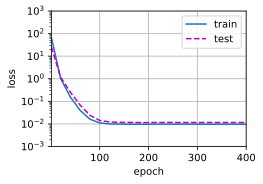

In [16]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(
    poly_features[:n_train, :4],
    poly_features[n_train:, :4],  # 传入features的前n_train行,前4列,作为训练集，其余行作为测试集(简单交叉验证)
    labels[:n_train],
    labels[n_train:],
)
true_w

欠拟合

weight: [[1.7766321 5.949997 ]]


array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

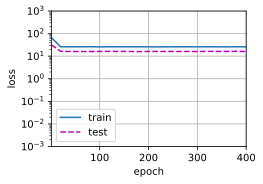

In [17]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])
true_w

过拟合

weight: [[ 4.978869    1.25909    -3.3620284   5.2863984  -0.19528566  0.7587941
   0.55087197 -0.29063487  0.12316661 -0.23314531 -0.09984875  0.19802643
  -0.18505152  0.02961162 -0.07154928  0.22049913 -0.16307186  0.17941137
  -0.00756482  0.08748368]]


array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

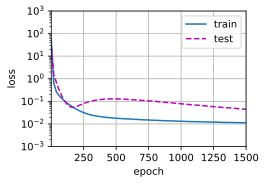

In [13]:
# 从多项式特征中选取所有维度
#效果不明显可略微提高初始x的值，使得干扰项的作用更大
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)
true_w